In [1]:
import os
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import scvi
from feature_attribution_sc.explainers.mask import mask, generate_rankings

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/pytorch_lightning/__init__.py:28: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
Global seed set to 0
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/flax/struct.py:133: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  ja

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.3 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


In [18]:
hlca_path = '../datasets/hlca.h5ad'
adata = sc.read(hlca_path)
adata

AnnData object with n_obs × n_vars = 584944 × 2000
    obs: 'sample', 'original_celltype_ann', 'study_long', 'study', 'last_author_PI', 'subject_ID', 'subject_ID_as_published', 'pre_or_postnatal', 'age_in_years', 'age_range', 'sex', 'ethnicity', 'mixed_ethnicity', 'smoking_status', 'smoking_history', 'BMI', 'known_lung_disease', 'condition', 'subject_type', 'cause_of_death', 'sample_type', 'anatomical_region_coarse', 'anatomical_region_detailed', 'tissue_dissociation_protocol', 'cells_or_nuclei', 'single_cell_platform', "3'_or_5'", 'enrichment', 'sequencing_platform', 'reference_genome_coarse', 'ensembl_release_reference_genome', 'cell_ranger_version', 'disease_status', 'fresh_or_frozen', 'cultured', 'cell_viability_%', 'comments', 'Processing_site', 'dataset', 'anatomical_region_level_1', 'anatomical_region_level_2', 'anatomical_region_level_3', 'anatomical_region_highest_res', 'age', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'ann_highest_res', 'ann_ne

Sanity check - sparsity should decrease differently depending on ranking used.

task2_baselines-task2_random.csv
task2_differential_expression-task2_DE_cell_types.csv
task2_ablation-task2_abs.csv
task2_expected_gradients-task2_absolute_sum_expected_grads.csv


/tmp/ipykernel_3267854/3142723300.py:19: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


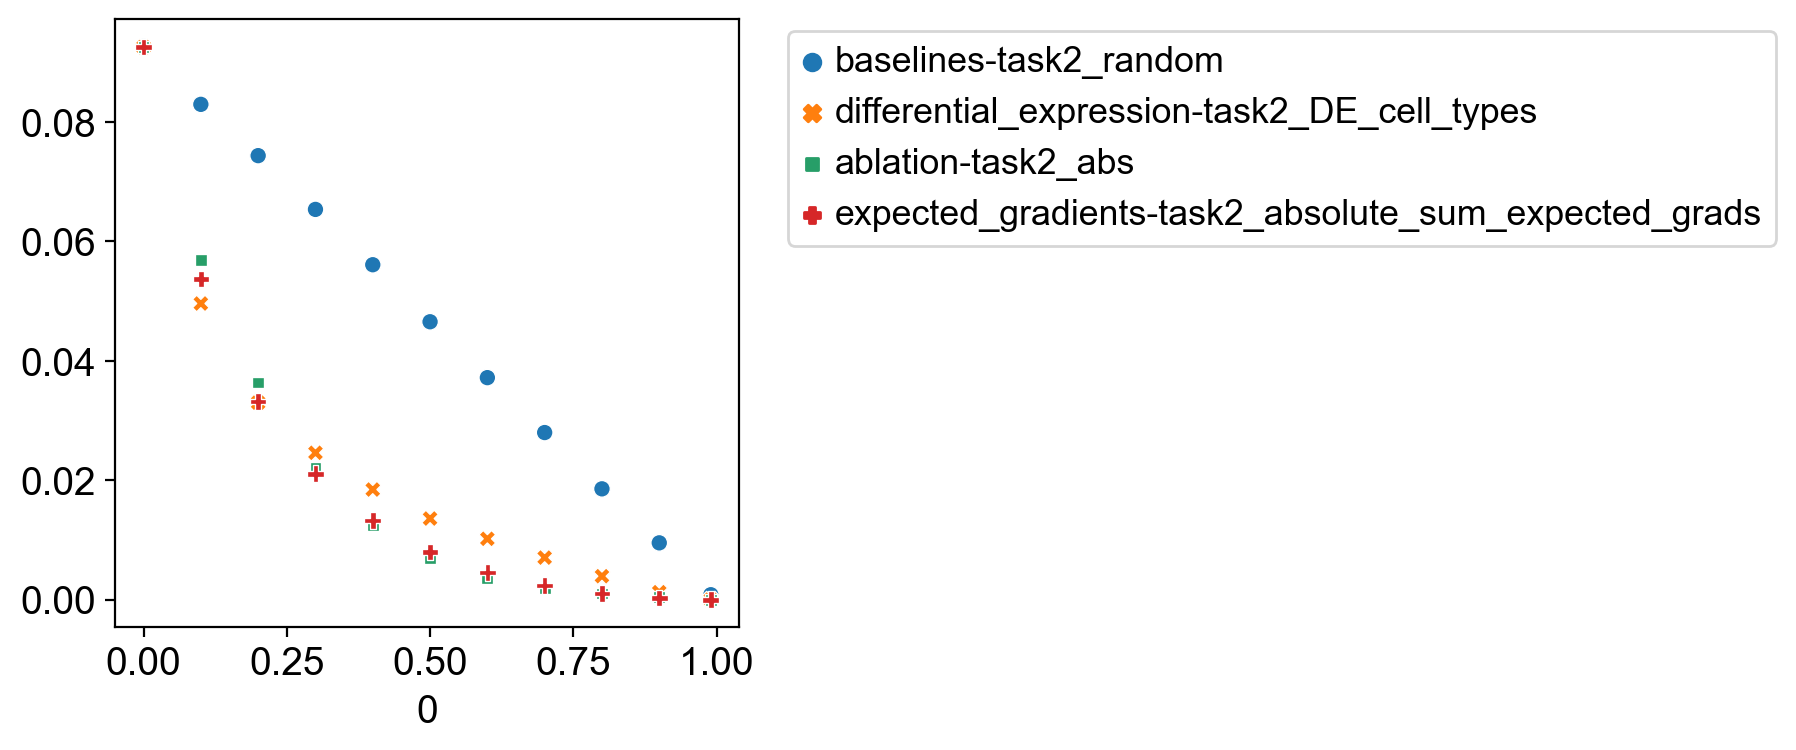

In [47]:
import os
import re

file_path = '/home/icb/yuge.ji/projects/feature-attribution-sc/scripts'

sparsity_files = {}
for f in os.listdir(f'{file_path}/sparsity'):
    if 'task2' in f and 'csv' in f:
        print(f)
        key = re.search(r'task2_(.*?)\.csv', f).group(1)
        sparsity_files[key] = f
    
df = pd.concat([
    pd.read_csv(f'{file_path}/sparsity/{f}', index_col=0, usecols=[1, 2]) for f in sparsity_files.values()
], axis=1)
df.columns = sparsity_files.keys()
sns.scatterplot(df)
plt.legend(bbox_to_anchor=(1.05, 1.01))
plt.grid(b=None)

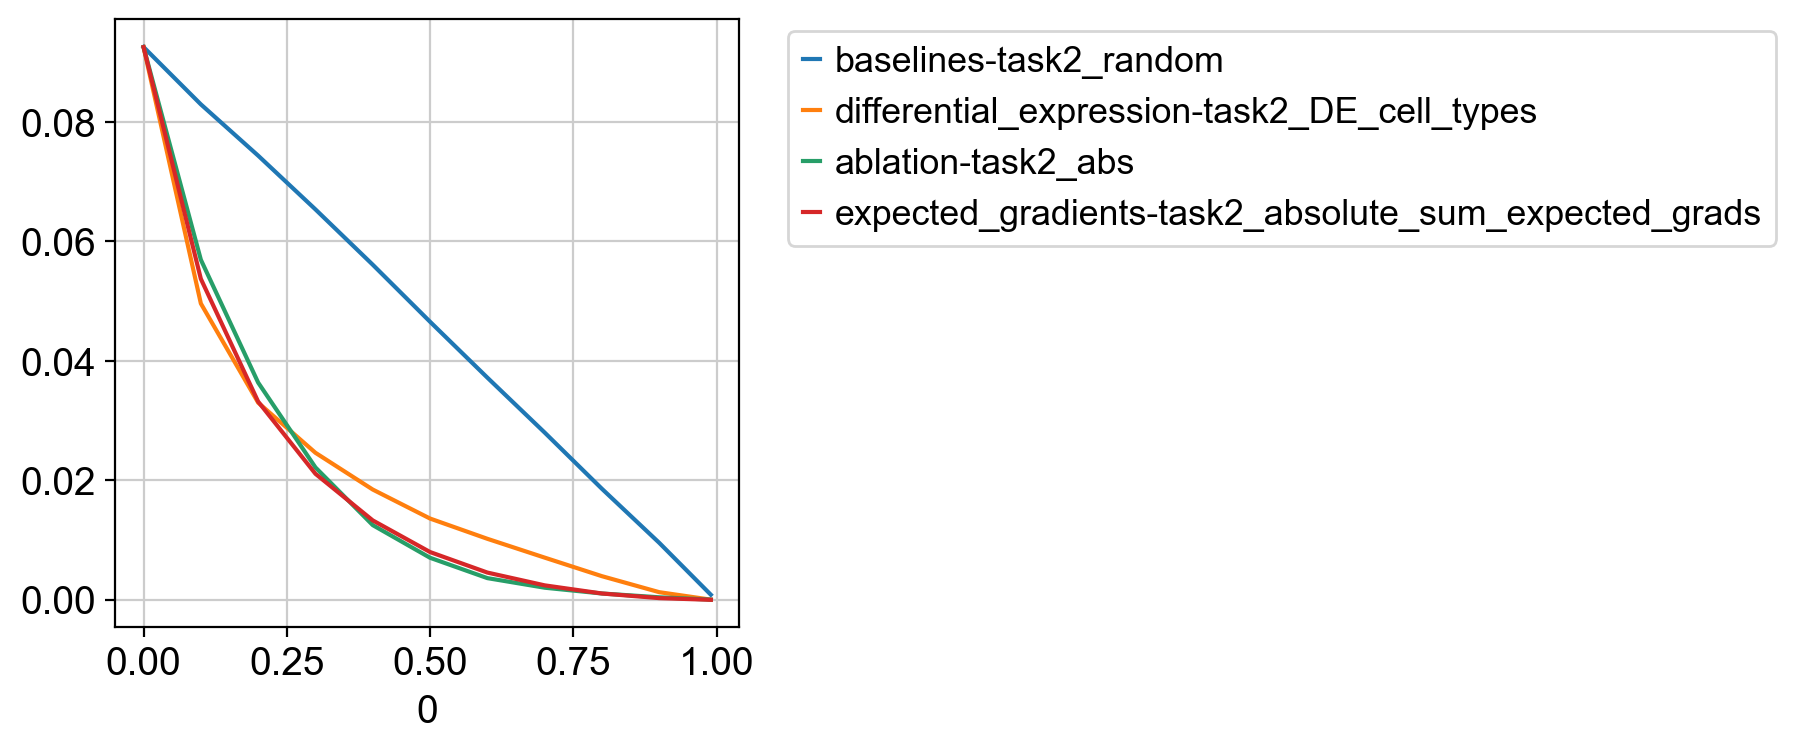

In [50]:
df.plot()
plt.legend(bbox_to_anchor=(1.05, 1.01))

## Plot performance metrics

In [3]:
from sklearn.metrics import f1_score, classification_report

In [52]:
%%time
# load in csvs
result_files = {}
for f in os.listdir(file_path):
    if 'masking_res_task2' in f and 'csv' in f:
        print(f)
        key = re.search(r'masking_res_task2_(.*?)\.csv', f).group(1)
        result_files[key] = pd.read_csv(f'{file_path}/{f}', index_col=0)

masking_res_task2_baselines-task2_random.csv
masking_res_task2_expected_gradients-task2_absolute_sum_expected_grads.csv
masking_res_task2_ablation-task2_abs.csv
masking_res_task2_differential_expression-task2_DE_cell_types.csv
CPU times: user 37.9 s, sys: 4.53 s, total: 42.5 s
Wall time: 43 s


In [53]:
%%time
f1_scores = []
for k, df in result_files.items():
    cols = [c for c in df.columns if 'masked_' in c]
    for obs_key in cols:
        threshold = obs_key.split('_')[-2]
        
        # because NaNs are assigned when a cell has a zero probability of being next to any other cell by pynndescent
        df = df.dropna(subset=[obs_key])
        
        # account for krasnow
        source = 'all'
        if 'krasnow' in obs_key:
            df = df[df[obs_key] != 'no_label']
            source = 'krasnow'
        
        f1_scores.append(
            (k, threshold, source, f1_score(df.scanvi_label.values, df[obs_key].values, average='macro'))
        )

CPU times: user 57.4 s, sys: 1.48 s, total: 58.9 s
Wall time: 59.2 s


/tmp/ipykernel_3267854/3510445992.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


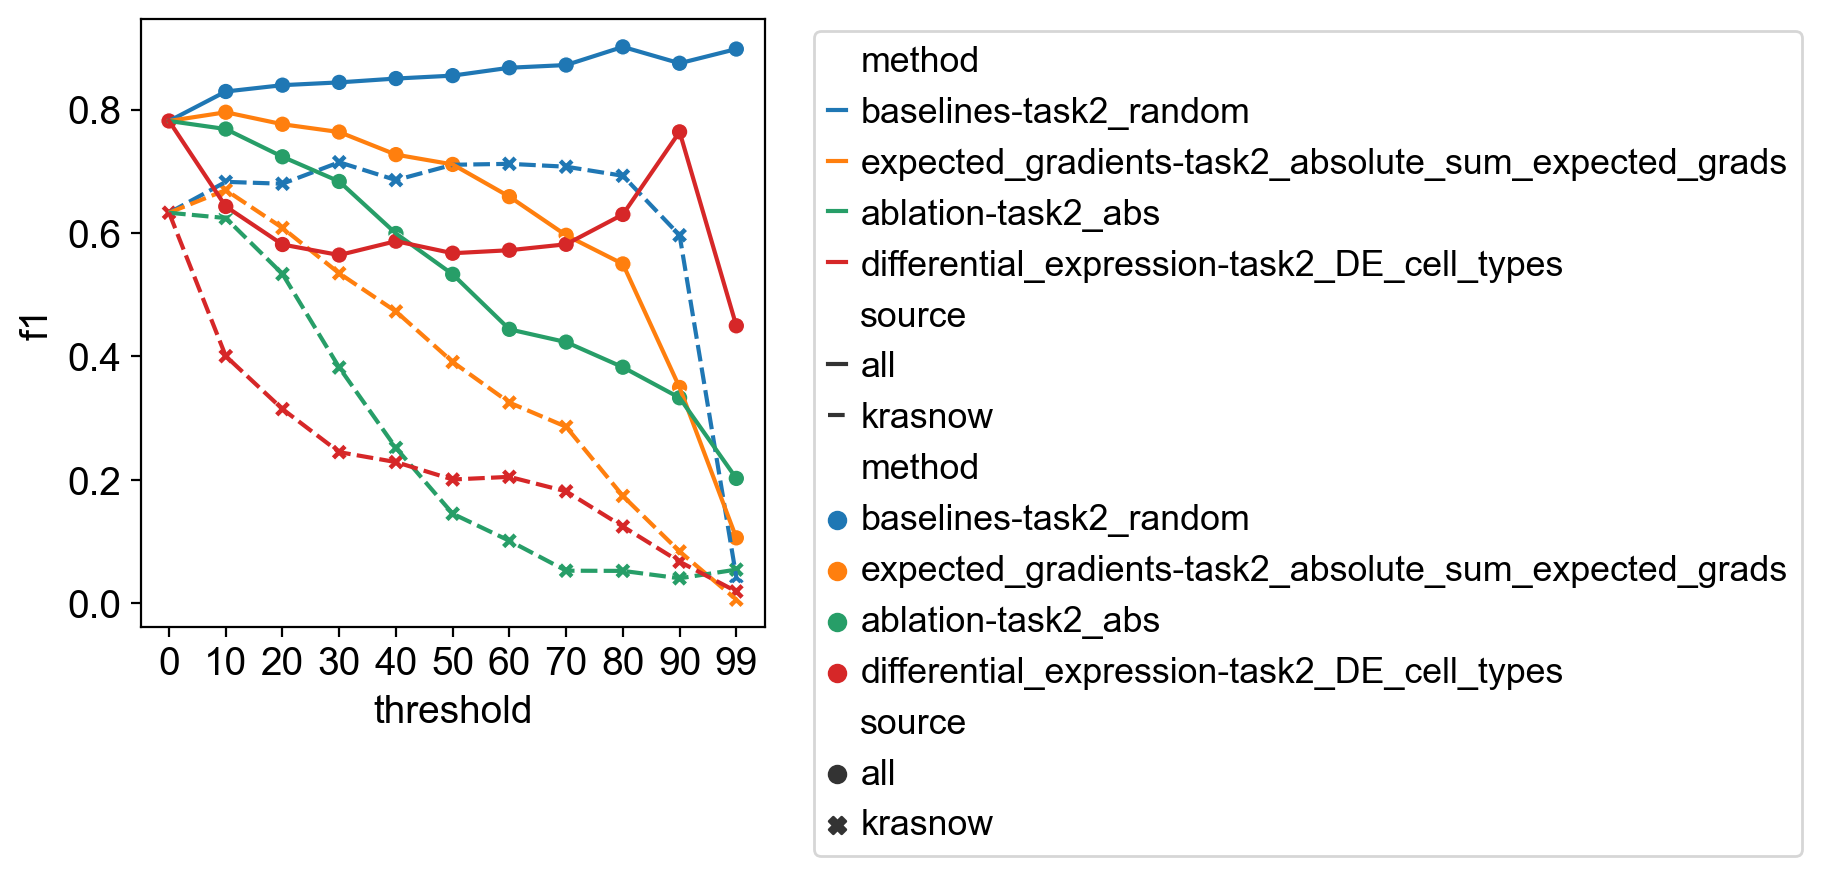

/tmp/ipykernel_3267854/3510445992.py:13: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


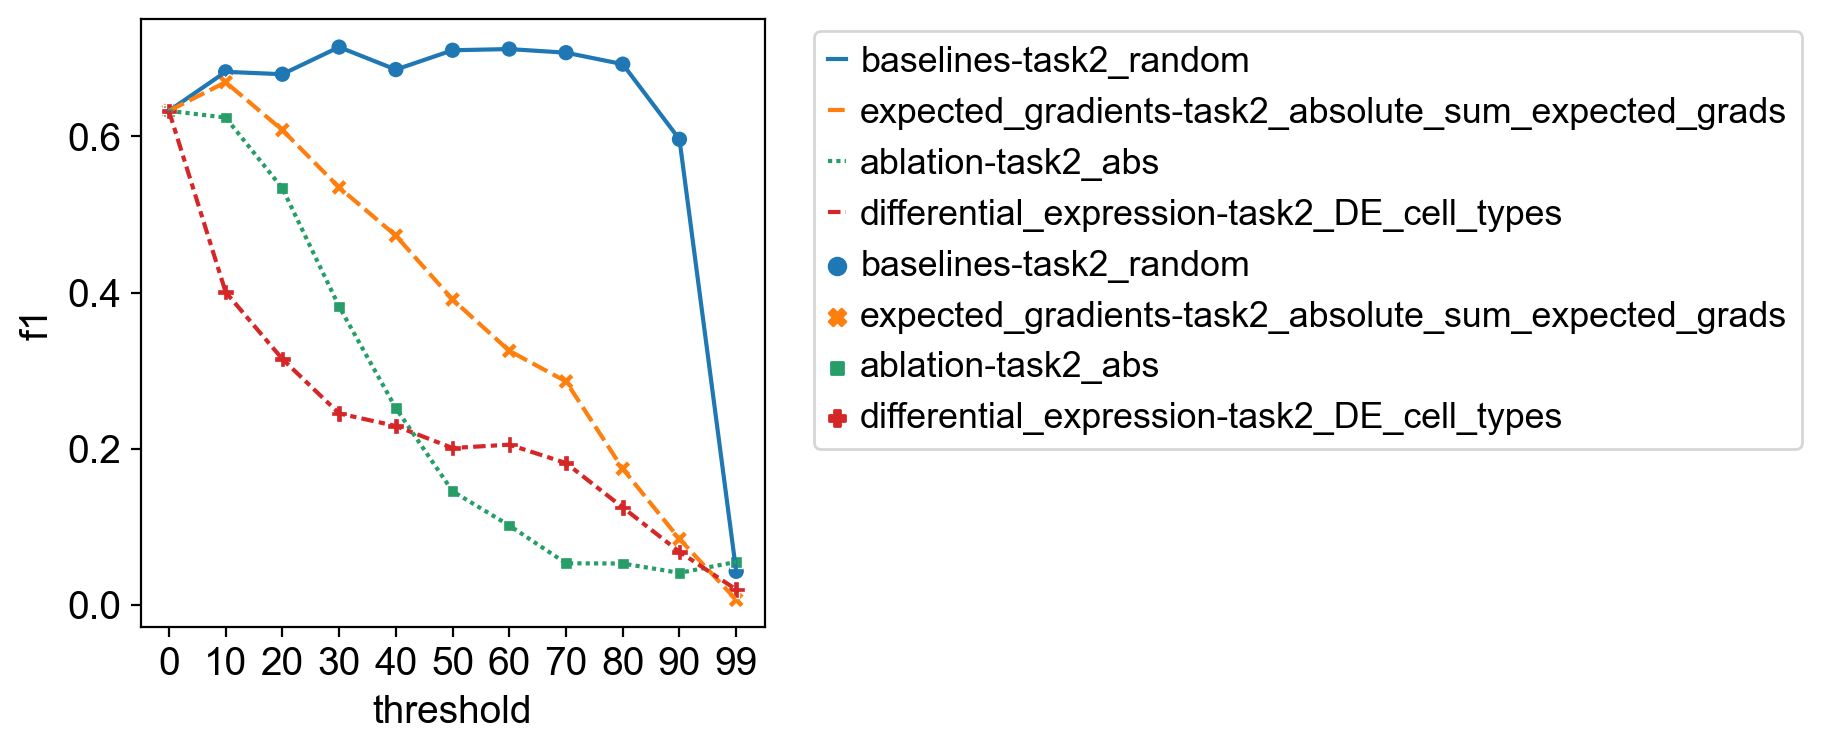

In [54]:
df = pd.DataFrame(f1_scores)
df.columns = ['method', 'threshold', 'source', 'f1']

sns.lineplot(data=df, x='threshold', y='f1', hue='method', style='source')
sns.scatterplot(data=df, x='threshold', y='f1', hue='method', style='source')
plt.legend(bbox_to_anchor=(1.05, 1.01))
plt.grid(b=None)
plt.show()

sns.lineplot(data=df[df.source == 'krasnow'], x='threshold', y='f1', hue='method', style='method')
sns.scatterplot(data=df[df.source == 'krasnow'], x='threshold', y='f1', hue='method', style='method')
plt.legend(bbox_to_anchor=(1.05, 1.01))
plt.grid(b=None)
plt.show()

## Mask and perform label transfer (old)

In [ ]:
# # data_path='/home/yuge/feature-attribution-sc'
# data_path = '/home/icb/yuge.ji/projects/feature-attribution-sc'

# feature_importance_files = [
# #     f'{data_path}/outputs/baselines/task2_random.csv',
# #     f'{data_path}/outputs/differential_expression/task2_DE_cell_types.csv',
# #     f'{data_path}/outputs/ablation/task2_abs.csv'
#     f'{data_path}/outputs/expected_gradients/task2_absolute_sum_expected_grads.csv'  # needs to contain something for unlabeled
# ]

# thresholds = list(range(10, 100, 60)) + [99]
# thresholds

# model = scvi.model.SCANVI.load('../models/scanvi_model/', adata)

In [5]:
# from scripts.mask import perform_label_transfer, generate_masked_inputs

In [7]:
sparsity_before = adata.X.nnz / (adata.shape[0] * adata.shape[1])
sparsity_before

0.09254418115238382

In [8]:
batch_size = adata.shape[0]
scdl = model._make_data_loader(adata=adata, indices=list(range(adata.shape[0])), batch_size=batch_size)
batch = next(scdl.__iter__())

/home/icb/yuge.ji/projects/feature-attribution-sc/outputs/expected_gradients/task2_absolute_sum_expected_grads.csv
Generating rankings for 29 labels and 2000 features.
0.1


/home/icb/yuge.ji/projects/feature-attribution-sc/feature_attribution_sc/explainers/mask.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(masked_data)


0.7
0.99


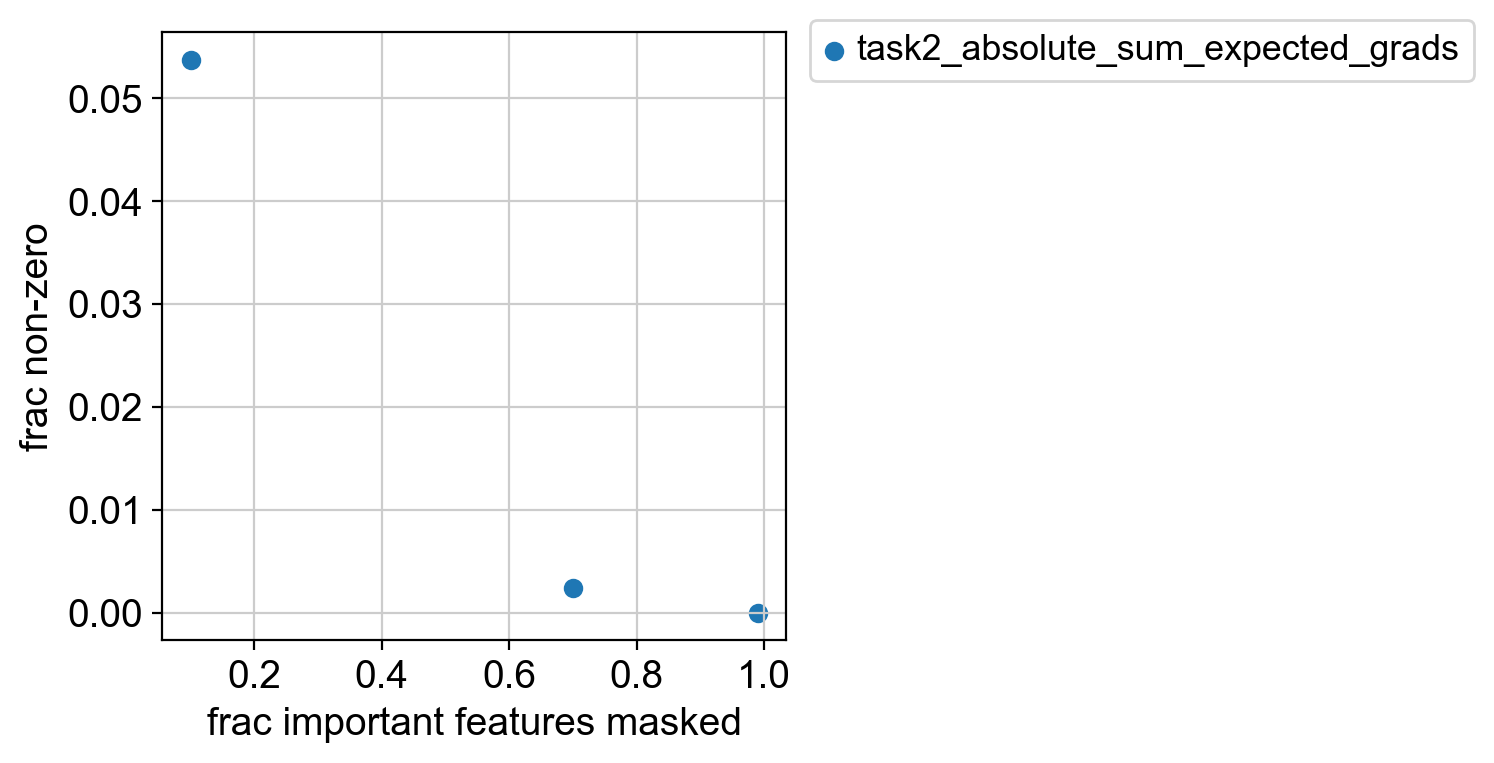

CPU times: user 6min 14s, sys: 22.9 s, total: 6min 37s
Wall time: 6min


In [9]:
%%time
attribution_masks = {}
for feature_importance in feature_importance_files:
    
    print(feature_importance)
    attrib_df = pd.read_csv(feature_importance)

    # reverse order for DE
    if 'differential_expression' in feature_importance:
        attrib_df[attrib_df.columns[1:]] *= -1
        
    # TODO: placeholder for unlabeled
    if 'unlabeled' not in attrib_df.columns:
        attrib_df['unlabeled'] = 0
    
    n_features = attrib_df.shape[0]
    if n_features < adata.shape[1]:
        raise ValueError(
            f"Attributions only calculated for {n_features} genes but adata has {adata.shape[1]}")
    elif n_features > adata.shape[1]:
        print(f'Only using attributions for {adata.shape[1]} genes.')
        attrib_df = attrib_df.set_index('gene_symbols').loc[adata.var_names].reset_index().rename({'index':'gene_symbols'}, axis=1)
    
#     rankings, gene_indices = generate_rankings(attrib_df)  # probably should generate gene indices from adata or idk?
    attribution_masks[feature_importance.split("/")[-2]], incremental_sparsity = \
        generate_masked_inputs(attrib_df, thresholds, batch)
    
    x, y = zip(*incremental_sparsity)
    plt.scatter(x, y, label=feature_importance.split('/')[-1].split('.')[0])

plt.ylabel('frac non-zero')
plt.xlabel('frac important features masked')
plt.legend(bbox_to_anchor=(1.01, 1.05))
plt.savefig('sparsity_test.png', bbox_inches='tight')
plt.show()

In [12]:
pd.DataFrame(incremental_sparsity).to_csv('sparsity_test.csv')

### Pass to model

In [36]:
# picking the one with best celltype coverage
pd.crosstab(adata.obs.dataset, adata.obs.scanvi_label).astype(bool).sum(axis=1)

dataset
Banovich_Kropski_2020        22
Barbry_Leroy_2020            16
Jain_Misharin_2021_10Xv1     11
Jain_Misharin_2021_10Xv2     11
Krasnow_2020                 24
Lafyatis_Rojas_2019_10Xv1    13
Lafyatis_Rojas_2019_10Xv2    13
Meyer_2019                   14
Misharin_2021                22
Misharin_Budinger_2018       11
Nawijn_2021                  17
Seibold_2020_10Xv2            5
Seibold_2020_10Xv3            5
Teichmann_Meyer_2019         15
dtype: int64

In [38]:
%%time
for k, masks_dict in attribution_masks.items():
    for threshold in thresholds:
        if threshold == 0:  # should be the same every time
            continue

        obs_key = f'{k}_masked_{threshold}_pred'

        if obs_key in adata.obs.columns:
            continue
        
        adata.X = masks_dict[f'masked_{threshold}']
        X = model.get_latent_representation(adata)
        
        ref_emb = ad.AnnData(X, obs=adata.obs)
#         query_emb = ref_emb[ref_emb.obs.dataset == 'Krasnow_2020'].copy()
        print('calculating neighbors on ref embedding for', obs_key)
        sc.pp.neighbors(ref_emb, n_neighbors=30)

        print('label transfer')
        _ = perform_label_transfer(
            ref_emb=ref_emb, query_emb=ref_emb, cell_type_column="scanvi_label"
        )
        
        if _ != -1:
            adata.obs[obs_key] = ref_emb.obs['transf_scanvi_label'].copy()

calculating neighbors on ref embedding for expected_gradients_masked_70_pred
label transfer
Failed to ingest due to duplicate cell embeddings.
calculating neighbors on ref embedding for expected_gradients_masked_99_pred
label transfer
Failed to ingest due to duplicate cell embeddings.
CPU times: user 28min, sys: 1min 5s, total: 29min 5s
Wall time: 4min 19s


In [12]:
ref_emb.uns['neighbors']

OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'n_neighbors': 30, 'method': 'umap', 'random_state': 0, 'metric': 'euclidean'}}
With overloaded keys:
	['connectivities', 'distances'].

In [ ]:
adata.obs.to_csv('hlca_masking_res_EG.csv')

Take a look at the last reference embedding, which is heavily masked.

In [ ]:
%%time
sc.tl.umap(ref_emb)

/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/yuge.ji/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


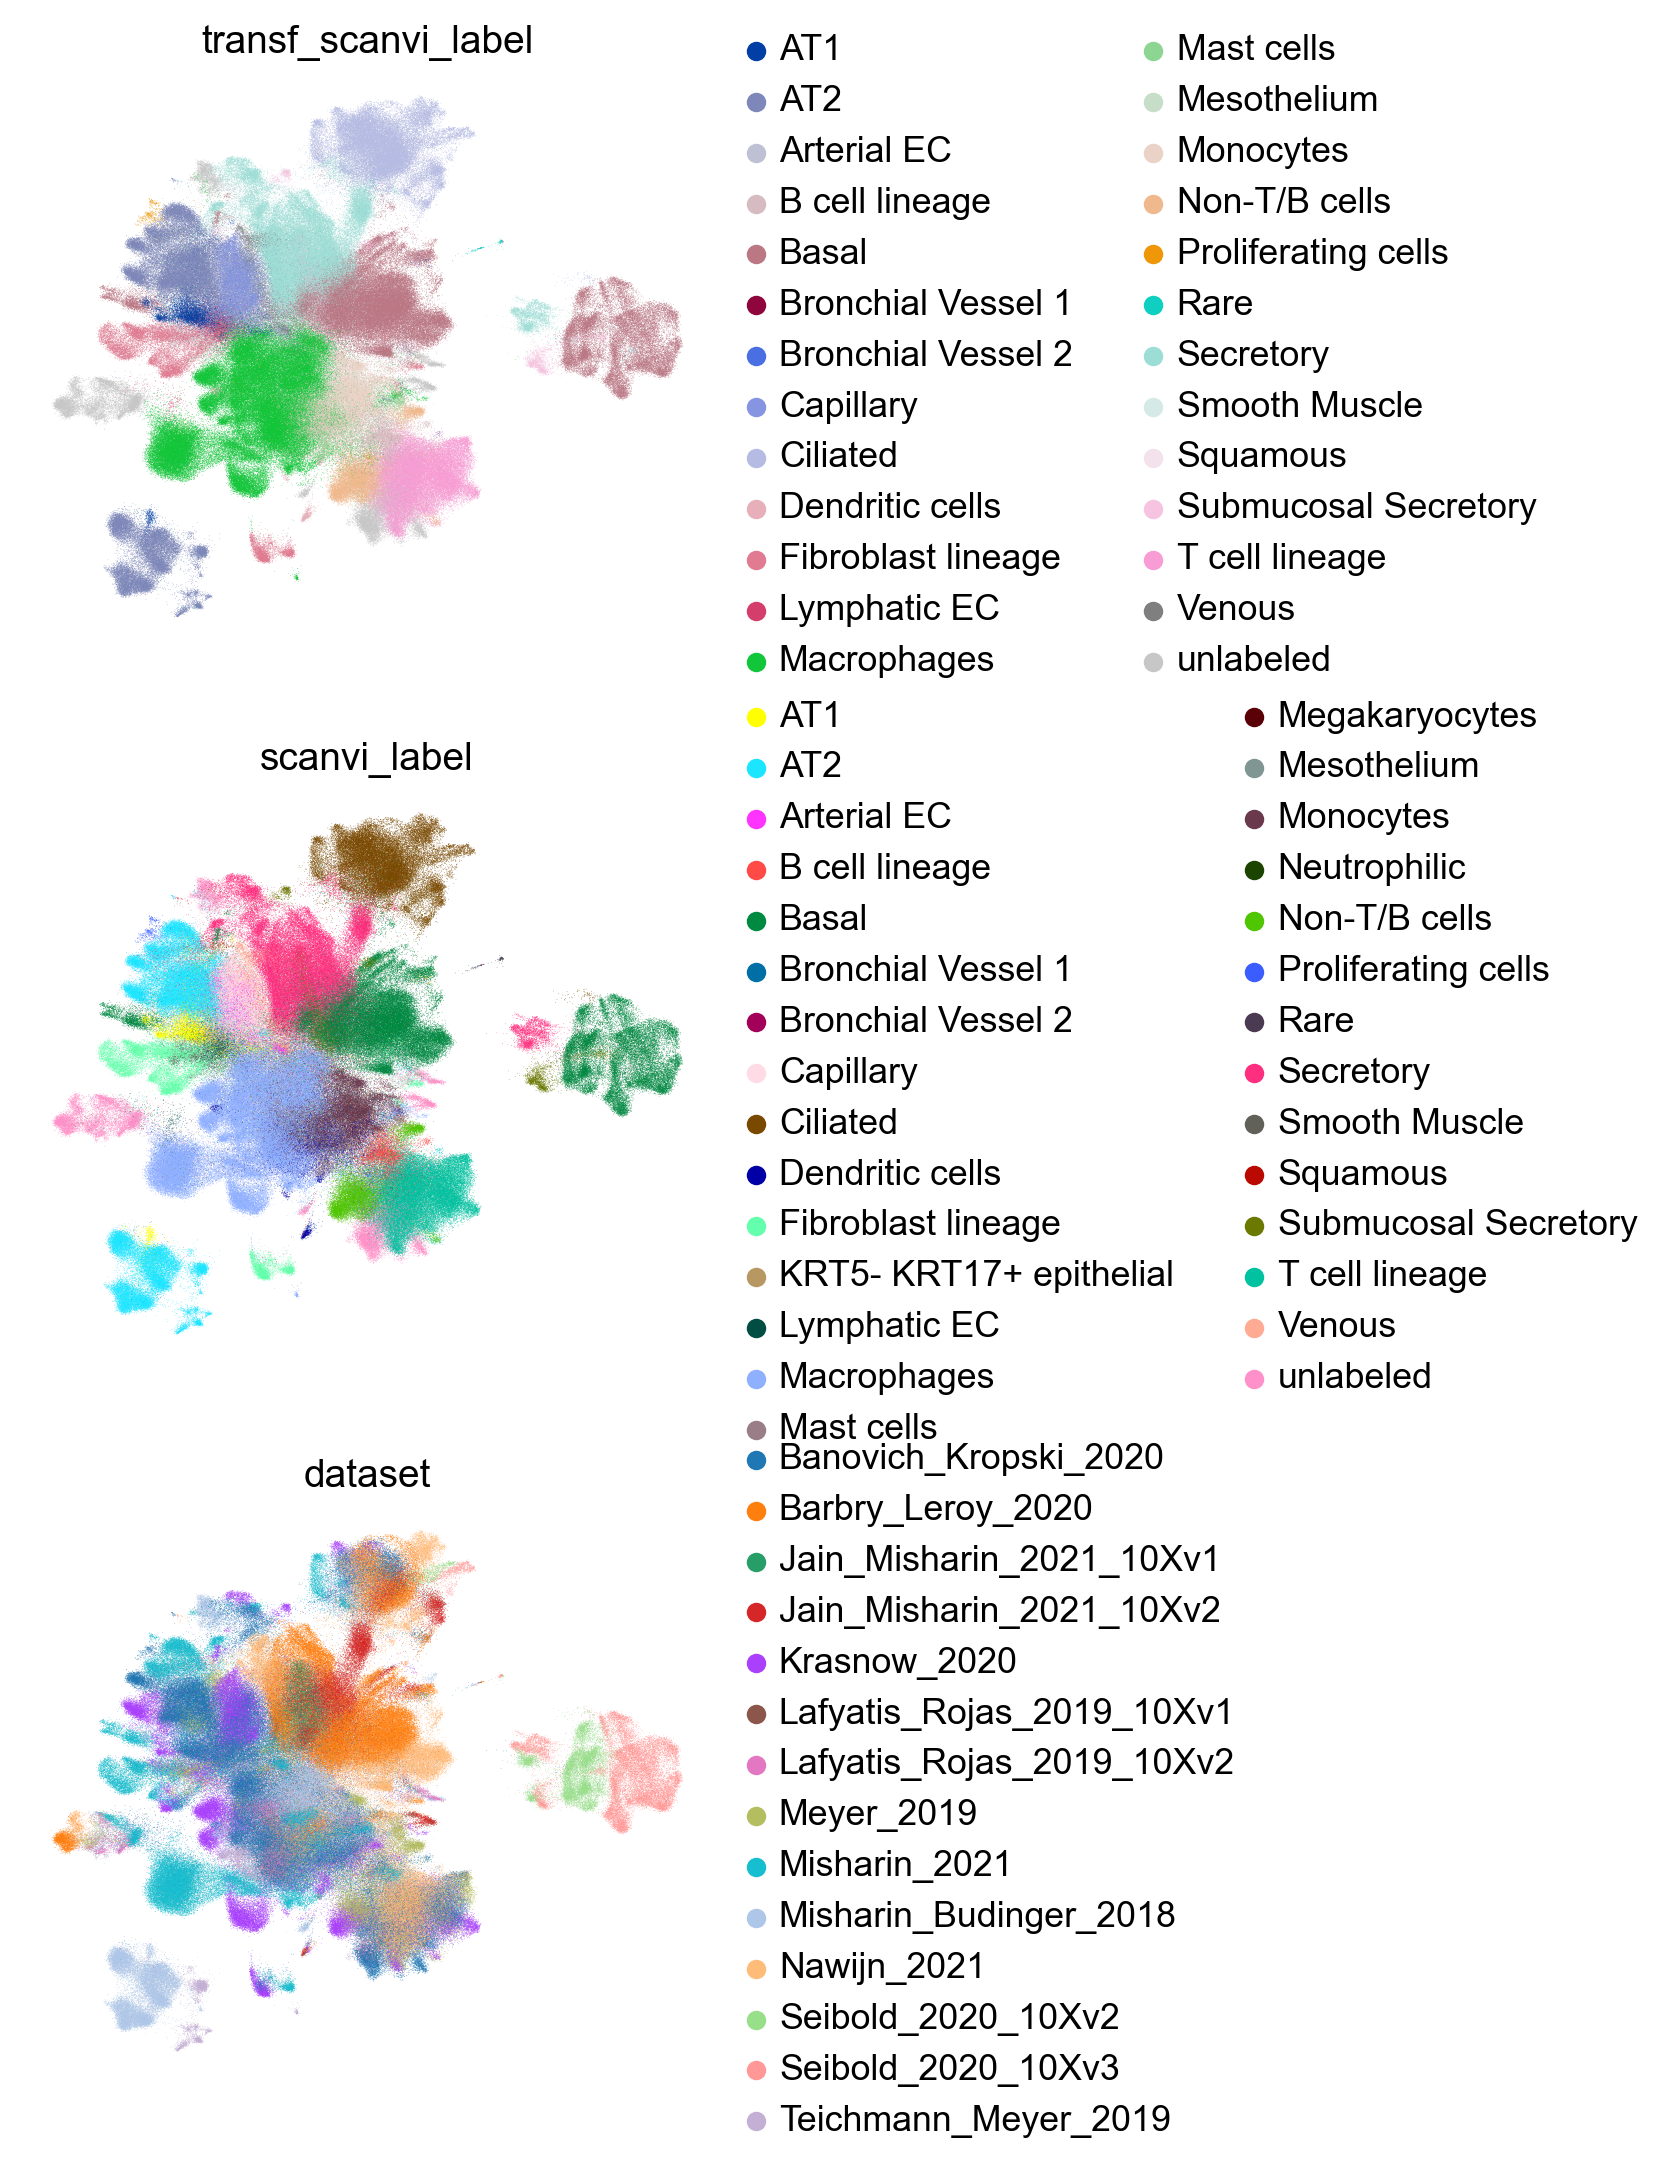

In [27]:
sc.pl.umap(ref_emb, color=['transf_scanvi_label', 'scanvi_label', 'dataset'], ncols=1)